## Introduction

>
>
>
>
>

Hi, and welcome to our CIS 545 Project! 

Our group members are :
- Kelly Liang
- Henry Hung
- Kun Hwi Ko

Today, we are here to do the following :

* Step 1 : Navigate through a movies dataset, and clean for necessary data 
* Step 2 : Visualize the data to get initial insights 
* Step 3 : Reformat the data to be compatible for machine learning 
* Step 4 : Use K-Means Clustering to forecast what movies users will like  

## Packages / Setup

In [1]:
%%capture 

# data cleaning and visualization packages 
!pip install pandasql
import collections 
import numpy as np 
import pandas as pd
import pandasql as ps 
import re 
import matplotlib.pyplot as plt 
import seaborn as sns  

# machine learning packages 
import sklearn


In [2]:
# Step 1 : install dependencies 
!pip install -q kaggle 

# Step 2 : create API Token from Kaggle and upload Kaggle.json 
# Instructions : https://www.kaggle.com/general/74235
from google.colab import files 
files.upload()


Saving kaggle.json to kaggle.json


{'kaggle.json': b'{"username":"kunhwiko","key":"ffde2dcdad62441bc64b6f73dbda3ec6"}'}

In [3]:
# Step 3: additional steps 
!mkdir ~/.kaggle 
!cp kaggle.json ~/.kaggle/
!chmod 600 ~/.kaggle/kaggle.json

# Step 4 : download the dataset 
# https://www.kaggle.com/rounakbanik/the-movies-dataset
!kaggle datasets download -d rounakbanik/the-movies-dataset

# Step 5 : Unzip the files 
!unzip the-movies-dataset.zip

 93% 212M/228M [00:01<00:00, 161MB/s]
100% 228M/228M [00:01<00:00, 181MB/s]
Archive:  the-movies-dataset.zip
  inflating: credits.csv             
  inflating: keywords.csv            
  inflating: links.csv               
  inflating: links_small.csv         
  inflating: movies_metadata.csv     
  inflating: ratings.csv             
  inflating: ratings_small.csv       


## Data Cleansing

In [4]:
# retrieve Kaggle data 

ratings_df = pd.read_csv("/content/ratings.csv")
keywords_df = pd.read_csv("/content/keywords.csv")
movies_df = pd.read_csv("/content/movies_metadata.csv")

/usr/local/lib/python3.6/dist-packages/IPython/core/interactiveshell.py:2718: DtypeWarning: Columns (10) have mixed types.Specify dtype option on import or set low_memory=False.
  interactivity=interactivity, compiler=compiler, result=result)


Let's start by cleansing the keywords, movies, and rating dataframe.

In [5]:
# cleansing keywords

# Step 1 : get rid of rows without any keywords 
keywords_df = keywords_df[keywords_df['keywords'] != '[]']

# Step 2 : convert str --> [array of words]
def str_parser(strs):
  res = re.findall("name': '(.*?)'", strs)
  return res if res else None 

keywords_df['keywords'] = keywords_df['keywords'].apply(lambda x : str_parser(x))
keywords_df.dropna(inplace=True)

In [6]:
# cleansing movies

# Step 1 : drop unnecessary columns 
movies_df.drop(columns = ['adult', 'belongs_to_collection', 'budget', 'homepage', \
                          'imdb_id', 'original_language', 'original_title', 'overview', \
                          'poster_path', 'production_countries', 'release_date', 'revenue', \
                          'runtime', 'spoken_languages', 'status', 'tagline', 'video'], inplace = True)

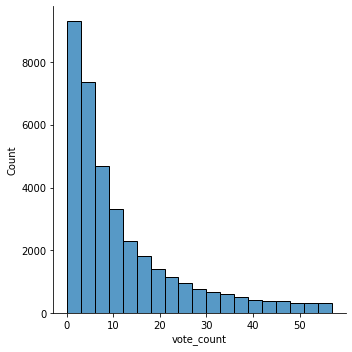

In [7]:
# Step 2: drop movies that not many people have watched as it can create bias 
sns.displot(movies_df, x = "vote_count", bins = [i for i in range(0, 60, 3)])
vote_threshold = 3
movies_df = movies_df[movies_df['vote_count'] >= vote_threshold]

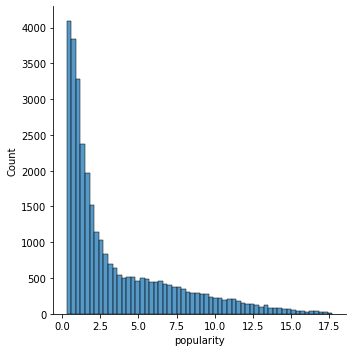

In [8]:
# Step 3: drop non-popular movies as they will likely not be recommended
movies_df['popularity'] = movies_df['popularity'].apply(lambda x : float(x))
sns.displot(movies_df, x = "popularity", bins = [i*0.3 for i in range(1, 60)])
popular_threshold = 0.6
movies_df = movies_df[movies_df['popularity'] >= popular_threshold]

In [9]:
# Step 4 : convert str --> [array of words]
movies_df['genres'] = movies_df['genres'].apply(lambda x : str_parser(x))
movies_df.dropna(inplace=True)

movies_df['production_companies'] = movies_df['production_companies'].apply(lambda x : str_parser(x))
movies_df.dropna(inplace=True)

Now that movies and keywords have been cleaned, let's join the two together. 

In [10]:
# join movies_df and keywords_df 
movies_df['genres'] = movies_df['genres'].apply(lambda x : str(x))
movies_df['production_companies'] = movies_df['production_companies'].apply(lambda x : str(x))
keywords_df['keywords'] = keywords_df['keywords'].apply(lambda x : str(x)) 

query = '''
select m.id, title, 
production_companies, genres,
keywords, popularity, 
vote_average, vote_count
from movies_df as m
join keywords_df as k
on m.id = k.id
'''

movies_df = ps.sqldf(query, locals())

In [11]:
# cleansing ratings 

# Step 1 : ratings_df is a very large dataset sorted by userId 
# we do not need to use all of the users as part of training 
ratings_df = ratings_df[ratings_df['userId'] <= 10000]

# Step 2 : drop unnecessary columns 
ratings_df.drop(columns = ['timestamp'], inplace=True) 

In [12]:
# Step 3 : get rid of ratings for movies not in movies_df 
query = '''
select * 
from ratings_df 
where movieId in (
  select id 
  from movies_df
)
'''

ratings_df = ps.sqldf(query, locals())

In [13]:
# Step 4 : get rid of movies not rated in ratings_df 
query = '''
select * 
from movies_df 
where id in (
  select movieId 
  from ratings_df
)
'''

movies_df = ps.sqldf(query, locals())

In [14]:
# Finally convert columns to how we want them 
movies_df['genres'] = movies_df['genres'].apply(lambda x : eval("[" + x[1:-1] + "]")) 
movies_df['production_companies'] = movies_df['production_companies'].apply(lambda x : eval("[" + x[1:-1] + "]")) 
movies_df['keywords'] = movies_df['keywords'].apply(lambda x : eval("[" + x[1:-1] + "]"))

In [15]:
# Make sure we have enough unique users before continuing
query = '''
select userId, count(movieId)
from ratings_df
group by userId
'''

ps.sqldf(query, locals()).shape

(9779, 2)

## Data Exploration & Visualization


### **Popular movie producers**
Is it safe to assume that non-popular production companies didn't make any popular movies? Let's find out. 

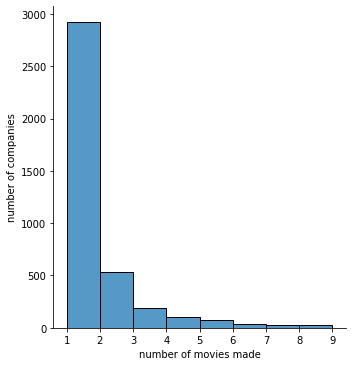

In [18]:
companies = [company for companies in movies_df['production_companies'] for company in companies]
freq = collections.Counter(companies)

ax = sns.displot(freq, x = freq.values(), bins = [i for i in range(1, 10)])
ax.set(xlabel='number of movies made', ylabel='number of companies')

From the plot above, we can tell there are a lot of companies that have made just 1 movie.

Now let's check if any of these companies have produced a movie that turned out to be a success.

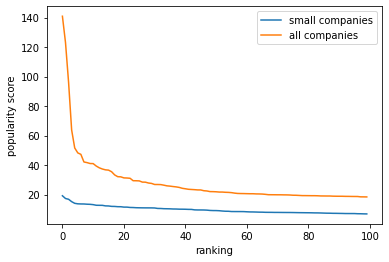

In [19]:
large_companies = {k for k,v in freq.items() if v > 1}
number_of_rows = movies_df.count()[0]

popularity_by_small_companies = []
popularity_by_all_companies = []

for i in range(number_of_rows):
  small = True 
  for company in movies_df['production_companies'].iloc[i]:
    if company in large_companies:
      small = False 
      break 
  if small:
    popularity_by_small_companies.append(movies_df['popularity'].iloc[i])
   
plt.plot(sorted(popularity_by_small_companies, reverse=True)[:100], label='small companies')  
plt.plot(sorted(movies_df['popularity'], reverse=True)[:100], label='all companies') 
plt.xlabel('ranking'); plt.ylabel('popularity score')
plt.legend()

It appears small companies never made any movies that are within the top 100 popular movies.

However, looking at our graph, it appears that starting from the 40th most popular movie, there really isn't a large discrepency that proves small companies make only non-popular movies. 

Therefore, we can disregard production companies as a factor for recommending movies. 


In [20]:
movies_df.drop(columns = ['production_companies'], inplace=True)

### **Genres & Individual User Rating**

So now let's look at the genre column.

/usr/local/lib/python3.6/dist-packages/seaborn/_decorators.py:43: FutureWarning: Pass the following variables as keyword args: x, y. From version 0.12, the only valid positional argument will be `data`, and passing other arguments without an explicit keyword will result in an error or misinterpretation.
  FutureWarning


Text(0, 0.5, 'count')

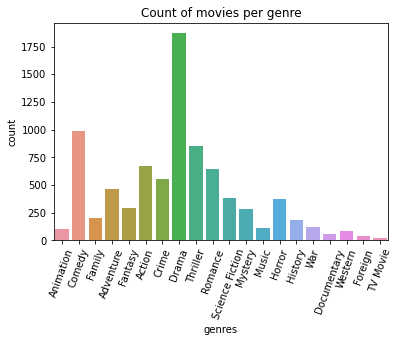

In [21]:
all_genres = {}

for i in range(number_of_rows):
  for genre in movies_df['genres'].iloc[i]:
    all_genres[genre] = all_genres.get(genre, 0) + 1

sns.barplot(list(all_genres.keys()), list(all_genres.values()))
plt.xticks(rotation=70)

plt.title("Count of movies per genre")
plt.xlabel('genres')
plt.ylabel('count')  

It appears that there are a total of 20 genres.

The most popular genre is 'Drama', and the least popular is 'Foreign'. 

So let's discover how each user in ratings_df rates each category based on the movies they rated. 

In [22]:
# Step 1 : create a copy of ratings_df and merge genres from movies_df
genres_df = ratings_df.copy(deep=True)
movies_df['genres'] = movies_df['genres'].apply(lambda x : str(x))
movies_df['keywords'] = movies_df['keywords'].apply(lambda x : str(x))

query = '''
select *
from genres_df as g
join movies_df as m
on g.movieId = m.id
'''

genres_df = ps.sqldf(query, locals())
genres_df.drop(columns=['id', 'keywords', 'popularity',\
                        'vote_average', 'vote_count',
                        'movieId', 'title'], inplace=True)
genres_df.sort_values(by=['userId'], inplace=True)

movies_df['genres'] = movies_df['genres'].apply(lambda x : eval("[" + x[1:-1] + "]")) 
genres_df['genres'] = genres_df['genres'].apply(lambda x : eval("[" + x[1:-1] + "]")) 
movies_df['keywords'] = movies_df['keywords'].apply(lambda x : eval("[" + x[1:-1] + "]")) 

In [24]:
# Step 2 : append all the genres as columns 
number_of_rows = genres_df.count()[0]

for genre in all_genres.keys():
  genres_df[genre] = [0 for _ in range(number_of_rows)]

In [28]:
# Step 3 : assign scores to the columns 
for i in range(number_of_rows):
  for genre in genres_df['genres'].iloc[i]:  
    genres_df[genre].iloc[i] += genres_df['rating'].iloc[i]

/usr/local/lib/python3.6/dist-packages/pandas/core/indexing.py:670: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  iloc._setitem_with_indexer(indexer, value)


In [33]:
# Step 4 : group by to average
genres_df.drop(columns=['rating','genres'], inplace=True)

query = '''
select userId, avg(Animation) as avg_animation, avg(Comedy) as avg_comedy,
avg(Family) as avg_family, avg(Action) as avg_action, avg(Crime) as avg_crime,
avg(Drama) as avg_drama, avg(Thriller) as avg_thriller, avg(Romance) as avg_romance,
avg("Science Fiction") as avg_science_fiction, avg(Mystery) as avg_mystery, 
avg(Music) as avg_music, avg(Horror) as avg_horror, avg(War) as avg_war, 
avg(Documentary) as avg_documentary, avg(Western) as avg_western, 
avg("Foreign") as avg_foreign, avg("TV Movie") as avg_tv_movie
from genres_df
group by userId
'''

genres_df = ps.sqldf(query, locals())

In [34]:
# This dataframe shows the average rating for each genre for each user (based on userId)

genres_df.head()

,userId,avg_animation,avg_comedy,avg_family,avg_action,avg_crime,avg_drama,avg_thriller,avg_romance,avg_science_fiction,avg_mystery,avg_music,avg_horror,avg_war,avg_documentary,avg_western,avg_foreign,avg_tv_movie
0,1,0.0,1.888889,0.000000,0.000000,0.500000,3.111111,0.000000,1.111111,0.000000,0.111111,0.000000,0.000000,0.000000,0.0,0.000000,0.00,0.0
1,2,0.0,0.823529,0.176471,0.882353,0.176471,1.764706,0.470588,0.705882,0.235294,0.411765,0.058824,0.470588,0.176471,0.0,0.000000,0.00,0.0
2,3,0.0,2.000000,0.000000,0.750000,1.000000,2.125000,0.625000,1.250000,0.375000,0.375000,0.000000,0.000000,0.000000,0.0,0.000000,0.00,0.0
3,4,0.0,0.850000,0.000000,0.700000,0.850000,1.850000,0.550000,0.950000,0.200000,0.350000,0.000000,0.200000,0.000000,0.0,0.500000,0.05,0.0
4,5,0.0,1.111111,0.000000,0.666667,1.111111,3.000000,1.222222,1.111111,1.000000,0.555556,0.000000,0.555556,0.000000,0.0,0.444444,0.00,0.0


### **Frequency of Keywords** 

Given the plethora of keywords we are seeing in our dataset, it might be a good idea to see how they are distributed and count how many distinct keywords there are exactly. 

What you will find at the end of this section: 

1) Top 20 most popular keywords 

2) Top 20 least popular keywords (might be affected by alphabetical order)



In [ ]:
#creating copies of movies and ratings for further analyses
movies_copy = movies_df.copy()

In [ ]:
keywords_list = movies_copy.explode("keywords")['keywords'].tolist()

In [ ]:
temp = pd.DataFrame(keywords_list, columns=['keywords'])
temp['frequency'] = 1

keywords_df = temp.groupby('keywords', as_index=False).count().sort_values('frequency', ascending=False)
keywords_df['frequency'].count()

# there are a total of 7949 number of keywords from our data

7949

Text(0.5, 1.0, 'top 20 frequently used keywords')

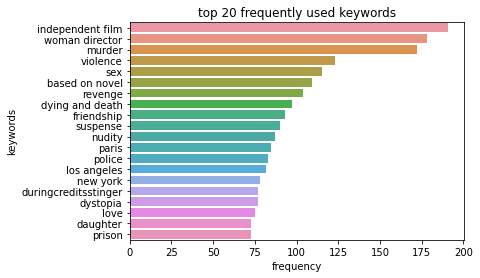

In [ ]:
sns.barplot(y='keywords', x='frequency', data=keywords_df.head(20))
plt.title("top 20 frequently used keywords")

In [ ]:
# a lot of the keywords are associated with only a few movies (highly specific keywords)
# we may want to get rid of these highly specific keywords

# average frequency of words = 3.58 
keywords_df['frequency'].mean() 

3.5823374009309346

In [ ]:
# there are 6156 keywords that appear less than 3 times
keywords_df[keywords_df['frequency']<=3]['keywords'].count()

6156

In [ ]:
# this generates the list of highly specific keywords
highly_specific_keywords = keywords_df[keywords_df['frequency']<=3]['keywords'].tolist()

In [ ]:
# when we get rid of these highly specific keywords, the average frequency increases substantially
# average frequency of words = 10.99
keywords_df[keywords_df['frequency']>3]['frequency'].mean()

10.987172336865589

In [ ]:
# we will focus on the "not so specific" keywords 
keywords_df = keywords_df[keywords_df['frequency']>3]
keywords = [word.lower() for word in keywords_list if word not in highly_specific_keywords]


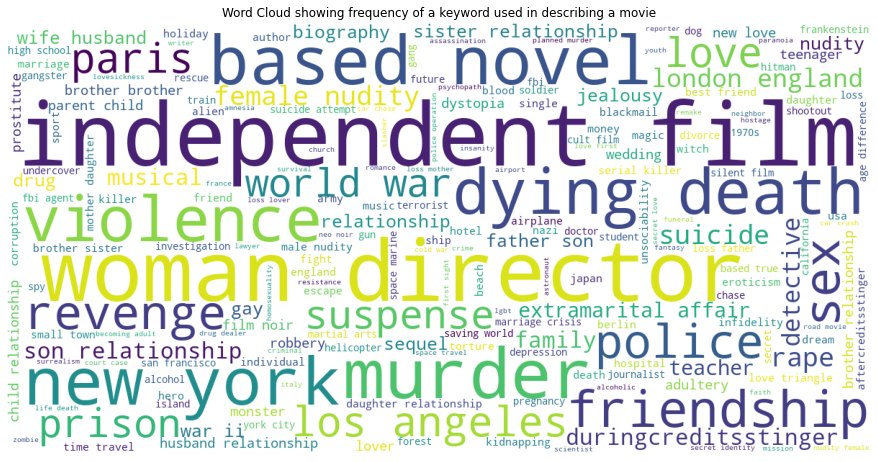

In [ ]:
from wordcloud import WordCloud, STOPWORDS 
    
comment_words = "" + " ".join(keywords) + " "

wordcloud = WordCloud(width = 1200, height = 600, 
                background_color ='white', 
                min_font_size = 10).generate(comment_words) 


plt.figure(figsize = (12, 6), facecolor = None) 
plt.imshow(wordcloud) 
plt.axis("off") 
plt.tight_layout(pad = 0) 

plt.title("Word Cloud showing frequency of a keyword used in describing a movie")
  
plt.show() 

From the above section, we now know the most popular keywords associated with different movies, as well as the least popular keywords. We can use these keywords later on for our machine learning model. 






### **Correlation between Popularity, Vote Count, Vote Average** 

Correlation can potentially be dangerous for statistics and machine learning. Let's try to get rid of as much correlation as possible.

In [ ]:
# popularity and vote count already by intuition are correlated 
# we drop vote count 

movies_df.drop(columns=['vote_count'], inplace=True)

Now let's investigate if popularity is correlated with better ratings.

In other word, does the vote average somehow bias the popularity (or vice versa)?

In [ ]:
temp = movies_df[['popularity', 'vote_average']]
temp.corr()

,popularity,vote_average
popularity,1.000000,0.284986
vote_average,0.284986,1.000000


It appears that there isn't a strong enough evidence to support that the average rating is correlated with popularity. 

### **Correlation between Frequency and Popularity of Keywords**

Now let's answer : Are frequently-used keywords associated with highly popular movies?

In [ ]:
popular_keywords = movies_df[['keywords', 'popularity']].explode('keywords').reset_index()
popular_keywords = popular_keywords.groupby('keywords', as_index=False)[['keywords', 'popularity']].mean().\
                          sort_values('popularity', ascending=False)

filtered_popular_keywords = popular_keywords[popular_keywords['keywords'].isin(keywords)] 

Text(0.5, 1.0, 'top 20 keywords used to describe popular movies')

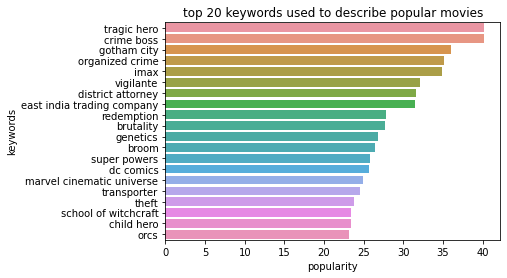

In [ ]:
sns.barplot(y='keywords', x='popularity', data=filtered_popular_keywords.head(20))
plt.title('top 20 keywords used to describe popular movies')

In [ ]:
query = '''
select k.keywords, k.frequency, f.popularity
from keywords_df as k
join filtered_popular_keywords as f
on k.keywords = f.keywords
'''

freq_pop = ps.sqldf(query)
freq_pop.corr()

,frequency,popularity
frequency,1.000000,-0.047616
popularity,-0.047616,1.000000


It appears that there isn't a correlation between frequency and popularity! 

## Towards Machine Learning

### **Common Keywords for Each Genre** 


One way of thinking about building a movie recommendation system is by building a regression model using different attributes/features. Some major features would be genres and keywords, as they are closely associated with the content of the movie. However, there are too many keywords associated with each movie in our database. 

This section explores relations between keywords and genres to see if dimension reduction can be done (take out generic keywords, for example)

In [ ]:
# build a dataframe to explore what keywords belong to what genres  
keyword_to_genres = movies_df[['keywords', 'genres']] 
keyword_to_genres = keyword_to_genres.explode('keywords').explode('genres')

In [ ]:
# group by keywords 
# the more genres are associated with a particular keyword, the more generic the keyword is 
# perhaps generic keywords will be less useful for our recommendation system 
temp = keyword_to_genres.groupby('keywords', as_index=False).count().sort_values('genres', ascending = False)

# on average the number of genres associated with a particular keyword is 9
# meanwhile the most generic words seem to be murder and independent film
temp['genres'].mean()

9.06982010315763

Text(0.5, 1.0, 'top 20 generic keywords to describe movies of different genres')

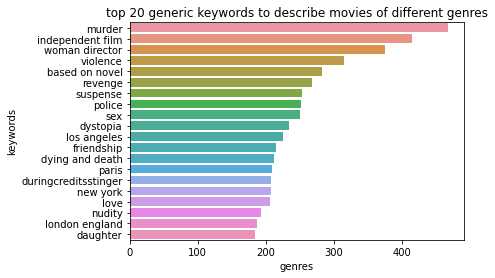

In [ ]:
sns.barplot(y='keywords', x='genres', data=temp.head(20))
plt.title("top 20 generic keywords to describe movies of different genres")

In [ ]:
# list of keywords that are generic AND
# list of keywords that are more specific to a particular genre 
generic_keywords = temp[temp['genres']>9]['keywords'].tolist()
specific_keywords = temp[temp['genres']<=9]['keywords'].tolist()

We can focus on the specific keywords so that we are not over-generalising the recommendation system.

Note that generic keywords do not necessarily entail frequent keywords (and vice versa).


In [ ]:
keywords = set(keywords_df['keywords'])

keywords_df = pd.DataFrame([word for word in specific_keywords if word in keywords], column=['keywords'])

In [ ]:
# now we only look at 206 keywords! 
len(keywords_df)

,0
0,relation
1,loss of sister
2,truck driver
3,rehabilitation
4,adolf hitler
...,...
201,synagogue
202,provence
203,cheerleader
204,cuban revolution


In [ ]:
genres_df

,userId,avg_animation,avg_comedy,avg_family,avg_action,avg_crime,avg_drama,avg_thriller,avg_romance,avg_science_fiction,avg_mystery,avg_music,avg_horror,avg_war,avg_documentary,avg_western,avg_foreign,avg_tv_movie
0,1,0.0,0.444444,0.000000,0.000000,0.111111,0.777778,0.000000,0.333333,0.000000,0.111111,0.000000,0.000000,0.000000,0.0,0.000000,0.00,0.0
1,2,0.0,0.294118,0.117647,0.235294,0.058824,0.588235,0.117647,0.176471,0.058824,0.117647,0.058824,0.117647,0.058824,0.0,0.000000,0.00,0.0
2,3,0.0,0.625000,0.000000,0.250000,0.375000,0.625000,0.250000,0.375000,0.125000,0.125000,0.000000,0.000000,0.000000,0.0,0.000000,0.00,0.0
3,4,0.0,0.300000,0.000000,0.200000,0.200000,0.500000,0.150000,0.300000,0.050000,0.100000,0.000000,0.050000,0.000000,0.0,0.100000,0.05,0.0
4,5,0.0,0.222222,0.000000,0.222222,0.222222,0.666667,0.333333,0.222222,0.222222,0.111111,0.000000,0.111111,0.000000,0.0,0.111111,0.00,0.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
9774,9995,0.0,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,1.000000,0.000000,0.0,0.000000,0.00,0.0
9775,9996,0.0,0.225806,0.000000,0.225806,0.129032,0.516129,0.354839,0.129032,0.129032,0.096774,0.000000,0.096774,0.000000,0.0,0.096774,0.00,0.0
9776,9997,0.0,0.400000,0.000000,0.233333,0.200000,0.633333,0.333333,0.366667,0.066667,0.066667,0.000000,0.066667,0.000000,0.0,0.033333,0.00,0.0
9777,9998,0.0,0.333333,0.000000,0.000000,0.000000,1.000000,0.000000,0.333333,0.333333,0.333333,0.000000,0.000000,0.000000,0.0,0.000000,0.00,0.0


**Find popularity's correlation with combination of keywords and genres?**



In [ ]:
pop_combo = movies_copy[['keywords', 'genres', 'popularity']].explode('keywords').explode('genres')
pop_combo.head()

,keywords,genres,popularity
0,jealousy,Animation,21.946943
0,jealousy,Comedy,21.946943
0,jealousy,Family,21.946943
0,toy,Animation,21.946943
0,toy,Comedy,21.946943


/usr/local/lib/python3.6/dist-packages/seaborn/_decorators.py:43: FutureWarning: Pass the following variables as keyword args: x, y. From version 0.12, the only valid positional argument will be `data`, and passing other arguments without an explicit keyword will result in an error or misinterpretation.
  FutureWarning


Text(0.5, 1.0, 'Mean Popularity of each Genre')

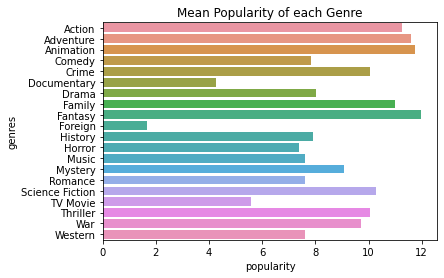

In [ ]:
genre_mean_popularity = pop_combo.groupby(['genres'], as_index=False).mean()
sns.barplot(genre_mean_popularity['popularity'], genre_mean_popularity['genres'])

plt.title("Mean Popularity of each Genre") 

In [ ]:
genre_mean_popularity

,genres,popularity
0,Action,11.270278
1,Adventure,11.588158
2,Animation,11.754059
3,Comedy,7.851989
4,Crime,10.056854
5,Documentary,4.248192
6,Drama,8.013488
7,Family,10.996259
8,Fantasy,11.990338
9,Foreign,1.659098


In [ ]:
pop_combo.groupby(['genres', 'keywords']).mean().sort_values('popularity', ascending=False).head()

popularity
genres   keywords                    
Thriller junkyard          140.950236
Crime    ambiguous ending  140.950236
         kamikaze          140.950236
         junkyard          140.950236
         pulp fiction      140.950236